In [1]:
from PIL import Image
import numpy as np
import os 
os.getcwd()

'/home/dahee/Lecture/AI621/HW1'

In [2]:
import matplotlib.pyplot as plt

## Initials

In [3]:
##### Load the image as a 2D array of unsigned interger #####
im = Image.open('./data/banana_slug.tiff')
im_array = np.array(im)
print(im_array)

[[2217 2391 2229 ... 2380 2236 2536]
 [2407 2209 2467 ... 2234 2470 2347]
 [2239 2437 2244 ... 2411 2208 2512]
 ...
 [2132 2146 2121 ... 2438 2686 2355]
 [2090 2106 2084 ... 2882 2375 2615]
 [2125 2131 2115 ... 2492 2821 2375]]


In [4]:
##### bits per integer in image #####
type(im_array[0][0])

numpy.uint16

In [5]:
##### width and height of image ##### 
print('The width of the image: ',im_array.shape[0])
print('The length of the image: ',im_array.shape[1])

The width of the image:  2856
The length of the image:  4290


In [6]:
##### convert into double-precision array #####

im_array = np.double(im_array)
type(im_array[0][0])

numpy.float64

## Linearlization

In [7]:
min_value = 2047
max_value = 15000
scaled_im_array = (im_array-min_value)/(max_value-min_value)
scaled_im_array = np.clip(scaled_im_array,0,1)

## Identifying the correct bayer pattern

In [8]:
im_r = scaled_im_array[0::2,1::2]
im_g = np.mean((scaled_im_array[0::2,0::2],scaled_im_array[1::2,1::2]),axis=0)
im_b = scaled_im_array[1::2,0::2]

bayer_candid1 = np.concatenate([im_r,im_g,im_b]).reshape(3,1428,2145)

In [9]:
im_r = scaled_im_array[0::2,0::2]
im_g = np.mean((scaled_im_array[0::2,1::2],scaled_im_array[1::2,0::2]),axis=0)
im_b = scaled_im_array[1::2,1::2]

bayer_candid2 = np.concatenate([im_r,im_g,im_b]).reshape(3,1428,2145)

In [10]:
im_r = scaled_im_array[1::2,1::2]
im_g = np.mean((scaled_im_array[0::2,1::2],scaled_im_array[1::2,0::2]),axis=0)
im_b = scaled_im_array[0::2,0::2]

bayer_candid3 = np.concatenate([im_r,im_g,im_b]).reshape(3,1428,2145)

In [11]:
im_r = scaled_im_array[1::2,0::2]
im_g = np.mean((scaled_im_array[0::2,0::2],scaled_im_array[1::2,1::2]),axis=0)
im_b = scaled_im_array[0::2,1::2]

bayer_candid4 = np.concatenate([im_r,im_g,im_b]).reshape(3,1428,2145)

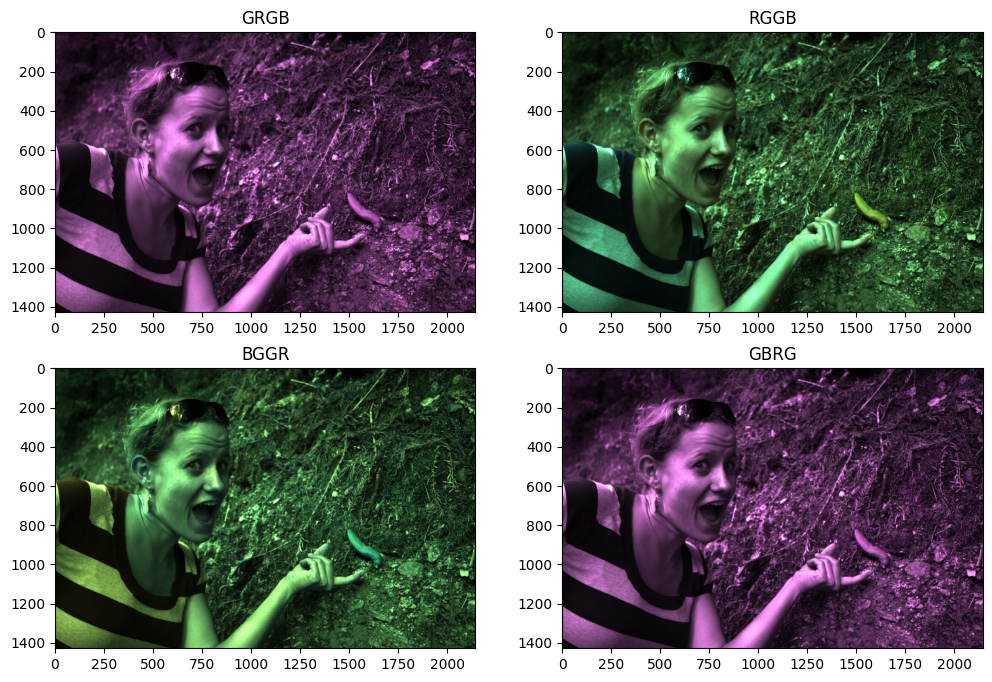

In [12]:
plt.figure(figsize = (12,8))

plt.subplot(2,2,1)
plt.imshow(np.clip(bayer_candid1 * 5,0,1).transpose(1,2,0))
plt.title('GRGB')

plt.subplot(2,2,2)
plt.imshow(np.clip(bayer_candid2 * 5,0,1).transpose(1,2,0))
plt.title('RGGB')

plt.subplot(2,2,3)
plt.imshow(np.clip(bayer_candid3 * 5,0,1).transpose(1,2,0))
plt.title('BGGR')

plt.subplot(2,2,4)
plt.imshow(np.clip(bayer_candid4 * 5,0,1).transpose(1,2,0))
plt.title('GBRG')

plt.show()

- For the green color, I use the mean value of two part. 
- I think the second Bayer pattern (RGGB) is the most appropreiate.
    - The overall color tone of the original image is blue/green rather than red, so second and third pattern (RGGB,BGGR) seems more appropriate. 
    - Among them, the second one respresents the contrast of colors better.

## White Balancing

In [13]:
r_avg = np.mean(bayer_candid2[0,:,:])
g_avg = np.mean(bayer_candid2[1,:,:])
b_avg = np.mean(bayer_candid2[2,:,:])

r_max = np.max(bayer_candid2[0,:,:])
g_max = np.max(bayer_candid2[1,:,:])
b_max = np.max(bayer_candid2[2,:,:])

In [14]:
im_array_grey = bayer_candid2.copy()
im_array_grey[0,:,:] = im_array_grey[0,:,:]*(g_avg/r_avg)
im_array_grey[2,:,:] = im_array_grey[2,:,:]*(g_avg/b_avg)

In [15]:
im_array_white = bayer_candid2.copy()
im_array_white[0,:,:] = im_array_white[0,:,:]*(g_max/r_max)
im_array_white[2,:,:] = im_array_white[2,:,:]*(g_max/b_max)

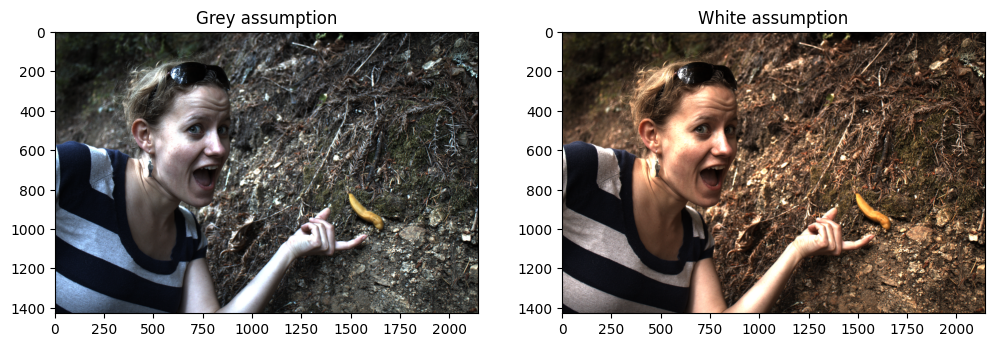

In [16]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.imshow(np.clip(im_array_grey*5,0,1).transpose(1,2,0))
plt.title('Grey assumption')

plt.subplot(1,2,2)
plt.imshow(np.clip(im_array_white*5,0,1).transpose(1,2,0))
plt.title('White assumption')

plt.show()

I think the grey assumption is better. With the white world assumption, reddish clolor cast isn't removed well.

Also, The final processed image with white world assumption seems still reddish compared to the image with gray world assumption. 

## DEMOSAICING

In [17]:
from scipy.interpolate import interp2d
x = np.arange(0,4290,2)
y = np.arange(0,2856,2)

x_new = np.arange(0,4290)
y_new = np.arange(0,2856)

In [18]:
demo_r = interp2d(x,y,im_array_grey[0,:,:],kind='linear')
demo_g = interp2d(x,y,im_array_grey[1,:,:],kind='linear')
demo_b = interp2d(x,y,im_array_grey[2,:,:],kind='linear')

In [19]:
d_r = demo_r(x_new,y_new)
d_g = demo_g(x_new,y_new)
d_b = demo_b(x_new,y_new)

In [20]:
demosaic_im = np.concatenate([d_r,d_g,d_b]).reshape(3,2856,4290)

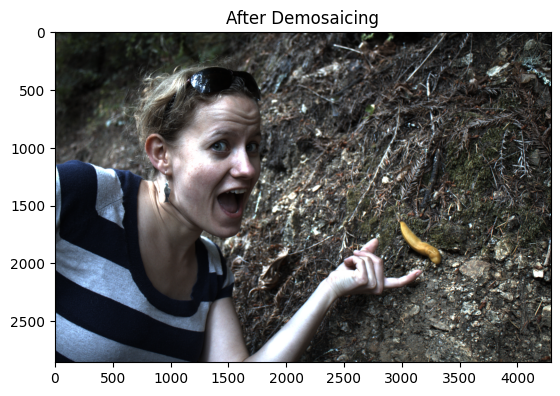

In [21]:
plt.imshow(np.clip(demosaic_im*5,0,1).transpose(1,2,0))
plt.title('After Demosaicing')
plt.show()

## BRIGHTNESS ADJUSTMENT AND GAMMA CORRECTION

In [22]:
import numpy as np
from skimage import color
gray_im = color.rgb2gray(demosaic_im.transpose(1,2,0))
max_gray_scale = np.max(gray_im)
max_gray_scale

0.8594521105016644

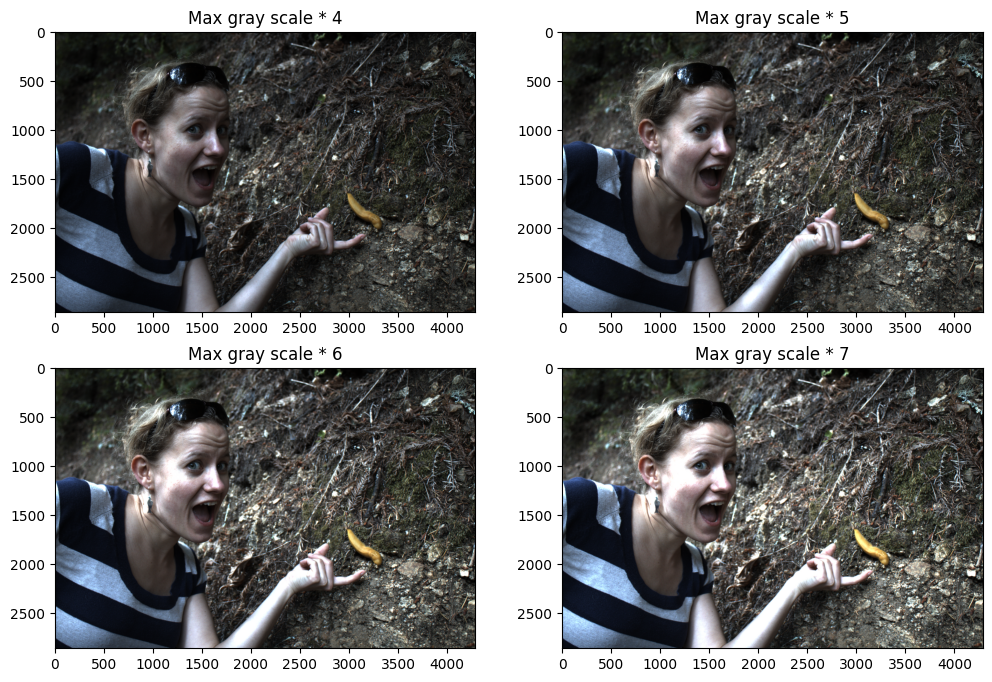

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
scale = max_gray_scale * 4
plt.imshow(np.clip(demosaic_im*scale,0,1).transpose(1,2,0))
plt.title('Max gray scale * 4')

plt.subplot(2,2,2)
scale = max_gray_scale * 5
plt.imshow(np.clip(demosaic_im*scale,0,1).transpose(1,2,0))
plt.title('Max gray scale * 5')

plt.subplot(2,2,3)
scale = max_gray_scale * 6
plt.imshow(np.clip(demosaic_im*scale,0,1).transpose(1,2,0))
plt.title('Max gray scale * 6')

plt.subplot(2,2,4)
scale = max_gray_scale * 7
plt.imshow(np.clip(demosaic_im*scale,0,1).transpose(1,2,0))
plt.title('Max gray scale * 7')

plt.show()

I think 5 times of maximum gray scale value looks best to me. 
- Less than max_gray_value*5 seems too dark and greater than max_gray_value*5 has too high contrast. 

In [25]:
scale = max_gray_scale * 5
im_array = np.clip(demosaic_im * scale,0,1)

In [26]:
g_correct_im = np.where(im_array<=0.0031308, im_array*12.92, (1+0.055)*im_array**(1/2.4)-0.055)

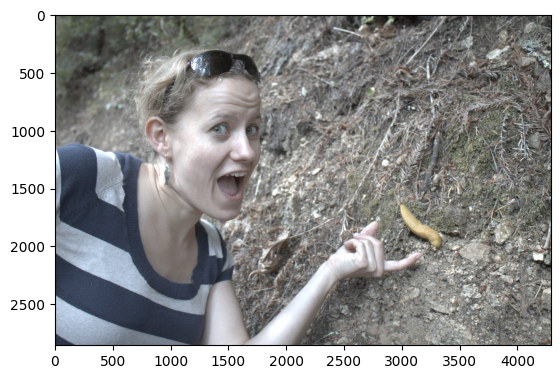

In [27]:
plt.imshow(g_correct_im.transpose(1,2,0))
plt.show()

## Compression

In [28]:
import cv2
save_im = (g_correct_im*255).transpose(1,2,0)

cv2.imwrite('hw1_no_compression.png',save_im)
cv2.imwrite('hw1_compression.jpeg',save_im, params=[cv2.IMWRITE_JPEG_QUALITY,95])

True

In [29]:
import os

jpeg_size = os.path.getsize('./hw1_compression.jpeg')
png_size = os.path.getsize('./hw1_no_compression.png')
print(jpeg_size)
print(png_size)
print('---------------------')
print('Compression ratio:{:.5f}'.format(jpeg_size/png_size))

3504179
19725302
---------------------
Compression ratio:0.17765


In [30]:
cv2.imwrite('hw1_compression_75.jpeg',save_im, params=[cv2.IMWRITE_JPEG_QUALITY,75])
cv2.imwrite('hw1_compression_50.jpeg',save_im, params=[cv2.IMWRITE_JPEG_QUALITY,50])
cv2.imwrite('hw1_compression_30.jpeg',save_im, params=[cv2.IMWRITE_JPEG_QUALITY,30])
cv2.imwrite('hw1_compression_25.jpeg',save_im, params=[cv2.IMWRITE_JPEG_QUALITY,25])
cv2.imwrite('hw1_compression_20.jpeg',save_im, params=[cv2.IMWRITE_JPEG_QUALITY,20])
cv2.imwrite('hw1_compression_15.jpeg',save_im, params=[cv2.IMWRITE_JPEG_QUALITY,15])
cv2.imwrite('hw1_compression_10.jpeg',save_im, params=[cv2.IMWRITE_JPEG_QUALITY,10])

True

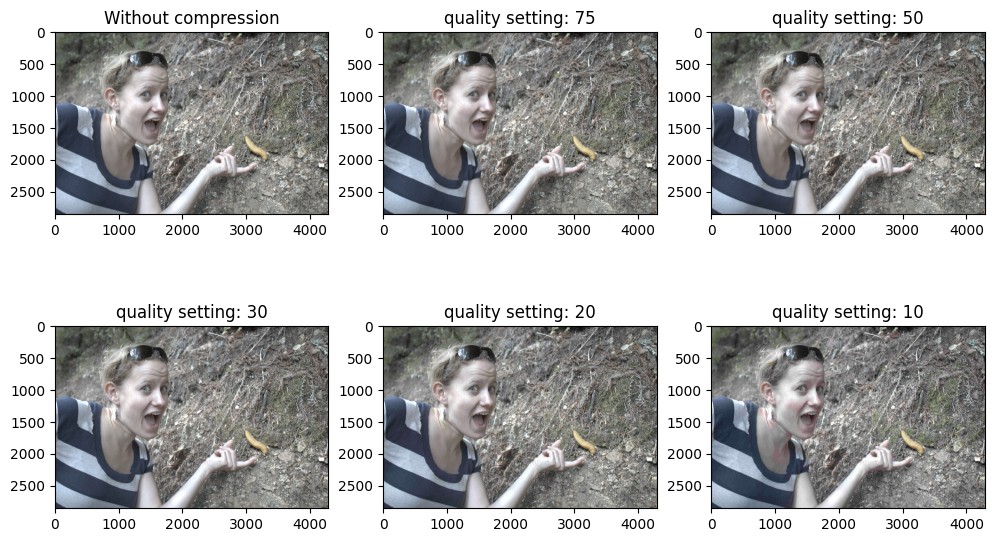

In [33]:
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
im = cv2.imread('./hw1_no_compression.png')
plt.imshow(im)
plt.title('Without compression')

plt.subplot(2,3,2)
im = cv2.imread('./hw1_compression_75.jpeg')
plt.imshow(im)
plt.title('quality setting: 75')

plt.subplot(2,3,3)
im = cv2.imread('./hw1_compression_50.jpeg')
plt.imshow(im)
plt.title('quality setting: 50')

plt.subplot(2,3,4)
im = cv2.imread('./hw1_compression_30.jpeg')
plt.imshow(im)
plt.title('quality setting: 30')

plt.subplot(2,3,5)
im = cv2.imread('./hw1_compression_20.jpeg')
plt.imshow(im)
plt.title('quality setting: 20')

plt.subplot(2,3,6)
im = cv2.imread('./hw1_compression_10.jpeg')
plt.imshow(im)
plt.title('quality setting: 10')

plt.show()

In [34]:
lowest_compress = os.path.getsize('./hw1_compression_30.jpeg')
print(lowest_compress/png_size)

0.03164139134599815


- For the quality setting 95, there is no visual difference. The Compression ratio is 0.177.
- I think the lowest setting for the compressing is quality 30. Lower than 30 makes the image corrupt, such as reddish noise. 

---------

### The result of white balancing (with white world assuption)

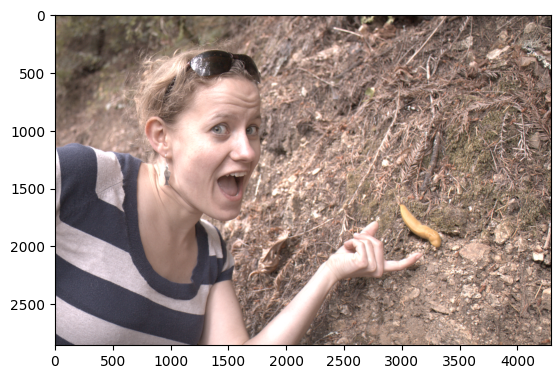

In [202]:
'''demosaicing'''
x = np.arange(0,4290,2)
y = np.arange(0,2856,2)
x_new = np.arange(0,4290)
y_new = np.arange(0,2856)

demo_r = interp2d(x,y,im_array_white[0,:,:],kind='linear')
demo_g = interp2d(x,y,im_array_white[1,:,:],kind='linear')
demo_b = interp2d(x,y,im_array_white[2,:,:],kind='linear')

d_r = demo_r(x_new,y_new)
d_g = demo_g(x_new,y_new)
d_b = demo_b(x_new,y_new)

demosaic_im = np.concatenate([d_r,d_g,d_b]).reshape(3,2856,4290)

'''brightening & gamma correction'''
im_array = demosaic_im * scale
g_correct_im = np.where(im_array<=0.0031308, im_array*12.92, (1+0.055)*im_array**(1/2.4)-0.055)

plt.imshow(np.clip(g_correct_im,0,1).transpose(1,2,0))
plt.show()